In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import pandas as pd

# 1. (12 points) The file CaCovidInfMarch24toMidJuly.txt 
on class website contains daily new cases of Covid-19 in CA from March 24
to mid July 2020, for a period of 120 days. Use the first 90 days for
training a linear regression model ( I = A + B t ) to predict the
infected cases the next 30 days. You may use Scikit-Learn functions.

### (a) Compute optimal solution by solving normal equation;

In [2]:
def Transform(X:list,n_feature=1):
    """
    Transform X into a poly nomial matrix M, where M[:,i] := X^(n-i)
    """
    X = np.array(X)
    A = np.zeros((X.size,n_feature+1))
    for i in range(n_feature+1):
        A[:,i] = (X**(i)).reshape(len(X))
    return A

In [3]:
Data = [float(line.rstrip('\n').strip()) for line in open('CaCovidInfMarch24toMidJuly.txt')]
X = [i+1 for i in range(len(Data))]
y_train = np.array(Data[:90] ).reshape(-1,1)
y_test = np.array(Data[90:]).reshape(-1,1)
x_train = Transform(X[:90])
x_test = Transform(X[90:])

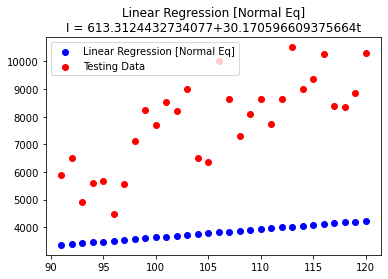

In [4]:
beta_a = np.linalg.inv(x_train.T@x_train)@x_train.T@y_train
y_pred_a = x_test@beta_a
plt.scatter(x_test[:,1],y_pred_a,c = 'b')
plt.scatter(x_test[:,1],y_test,c = 'r')
plt.legend(['Linear Regression [Normal Eq]','Testing Data'])
plt.title(f"Linear Regression [Normal Eq]\nI = {beta_a[0][0]}+{beta_a[1][0]}t")
plt.show()

### (b) compute optimal solution by full batch gradient descent;

In [5]:
def line_reg_grad_dec(X,Y,theta,Transform_fun,n_feature,eta = 0.002,n_iter = 1e3,tol = 1-3,plot = False):
    """
    @eta:learing rate
    @n_iter:number of interations before stopping 
    @theta:the initial guess for the coefficient
    """
    Y = Y.reshape(len(Y))
    A = Transform_fun(X,n_feature)
    for i in range(int(n_iter)):
        gradient = A.T@(A@theta-Y)
        temp = theta
        theta = theta - eta*gradient
        if np.linalg.norm(temp-theta) < tol:
            plt.show()
            return theta
        if all([plot,(i+1)%(n_iter/4) == 0]):
            xx = np.linspace(min(X),max(X),100)
            AA = Transform_fun(xx,n_feature)
            yy = AA@theta
            plt.plot(xx,yy,'-.')
    plt.show()
    return theta

In [6]:
def line_reg_grad_dec(X,Y,n_feature,theta = None,eta = 0.002,n_iter = 1e3,tol = 1-3,plot = False):
    """
    @eta:learing rate
    @n_iter:number of interations before stopping 
    @theta:the initial guess for the coefficient
    """
    if theta is None:
        theta = np.random.randn(x_train.shape[1],1)
    def Transform_fun(X:list,n_feature=1):
        """
        Transform X into a poly nomial matrix M, where M[:,i] := X^(n-i)
        """
        X = np.array(X)
        A = np.zeros((X.size,n_feature+1))
        for i in range(n_feature+1):
            A[:,i] = (X**(i)).reshape(len(X))
        return np.array(A)
    #_____________________________________________________#
    Y = Y.reshape(-1,1)
    A = Transform_fun(X,n_feature)
    for i in range(int(n_iter)):
        gradient = A.T@((A@theta).reshape(-1,1)-Y)
        temp = theta
        theta = theta.reshape(-1,1) - eta*gradient
        if np.linalg.norm(temp-theta) < tol:
            plt.show()
            return theta
        if all([plot,(i+1)%(n_iter/4) == 0]):
            xx = np.linspace(min(X),max(X),100)
            AA = Transform_fun(xx,n_feature)
            yy = AA@theta
            plt.plot(xx,yy,'-.')
    plt.show()
    return theta

In [7]:
beta_0 = np.array([100,10]).reshape(-1,1)
beta_b = line_reg_grad_dec(X = X[:90],Y = y_train,
                         n_feature = 1,eta = 0.000005, n_iter=1e5,plot = 0)

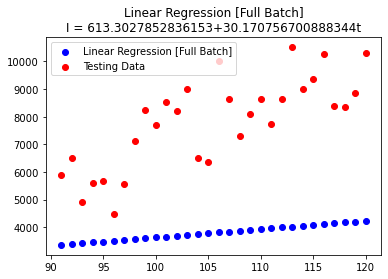

In [8]:
y_pred_b = x_test@beta_b
plt.scatter(x_test[:,1],y_pred_b,c = 'b')
plt.scatter(x_test[:,1],y_test,c = 'r')
plt.legend(['Linear Regression [Full Batch]','Testing Data'])
plt.title(f"Linear Regression [Full Batch]\nI = {beta_b[0][0]}+{beta_b[1][0]}t")
plt.show()

### (c) compute optimal solution by mini-batch (size 10) stochastic gradient descent;

In [9]:
def SGD(x_train,y_train,n_iterations,minibatch_size,theta=None,tol = 1e-3,t0=2,t1=5000):
    if theta is None:
        theta = np.random.randn(x_train.shape[1],1)
    #Learning Schedual:
    def learning_schedule(t):
        nonlocal t0
        nonlocal t1
        'Return step size based on the number of iteration'
        return t0/(t+t1)

    t = 0
    theta_path = [np.array([0,0])]
    for epoch in range(int(n_iterations)):
        theta_path.append(copy(theta))
        shuffled_idx = np.random.permutation(len(x_train))
        x_shuffled = x_train[shuffled_idx]
        y_shuffled = y_train[shuffled_idx]
        temp = theta
        for i in range(0,len(x_train),minibatch_size):
            t += 1 #Increase the counter
            xi = x_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size*xi.T@(xi@theta-yi) #Getting gradient based on the minibatch
            eta = learning_schedule(t)
            theta -= eta * gradients
        #print(np.linalg.norm(theta_path[-2]-theta_path[-1]))
        if np.linalg.norm(theta_path[-2]-theta_path[-1]) < tol:
            print(f"The coefficient succesfully converged at t = {t}, epoch = {epoch}")
            theta_path = np.array(theta_path[1:])
            return theta,theta_path
    print("Max Iteration Reached")
    theta_path = np.array(theta_path[1:])
    return theta,theta_path

In [10]:
n_iterations = 1e4 #Number epoch
minibatch_size = 10 #Selecting n random elements from X_train
np.random.seed(42)#Ensuring Generating Same Result
theta = np.random.randn(2,1) #Random Initialization
beta_c,theta_path = SGD(x_train,y_train,n_iterations,minibatch_size,t1 = 5000)

Max Iteration Reached


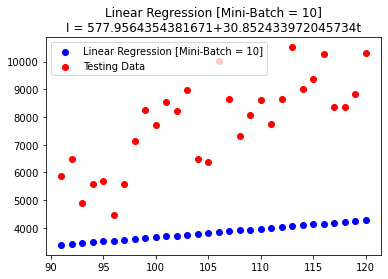

In [11]:
y_pred_c = x_test@beta_c
plt.scatter(x_test[:,1],y_pred_c,c = 'b')
plt.scatter(x_test[:,1],y_test,c = 'r')
plt.legend(['Linear Regression [Mini-Batch = 10]','Testing Data'])
plt.title(f"Linear Regression [Mini-Batch = 10]\nI = {beta_c[0][0]}+{beta_c[1][0]}t")
plt.show()

### (d) compute training and prediction mean square errors for solutions from (a), (b) and (c), and plot model outputs (in red for the first 90 days, in green for the remaining 30 days) along with data (in blue). 

In [12]:
def MSE(Y_true,Y_pred):
    return np.average([(i-j)**2 for i,j in zip(Y_true,Y_pred)])

In [13]:
def MSE_Summary(model_type,beta,x_train,y_train,x_test,y_test,
                MSE_record,train_size = 90, test_size = 30,plot = True):
    assert len(x_train) == train_size, f'x_train size is {len(x_train)} does not match expected size of: {train_size} '
    assert len(x_test) == test_size, f'x_test size is {len(x_test)} does not match expected size of: {test_size} '
    #Calculate MSE
    OUT = dict(MSE_record)
    yPred_train = x_train@beta
    yPred_test = x_test@beta
    MSE_train = MSE(Y_true = y_train,Y_pred = yPred_train)
    MSE_test = MSE(Y_true = y_test,Y_pred = yPred_test)
    OUT[model_type+'_train'].append(MSE_train)
    OUT[model_type+'_test'].append(MSE_test)
    #Plotting 
    if plot:
        #Red for predicted trained data
        plt.scatter(x_train[:,1],yPred_train,c = 'r')
        #green for predicted test data
        plt.scatter(x_test[:,1],yPred_test,c = 'g')
        #blue for original data
        plt.scatter(x_train[:,1],y_train,c='b')
        plt.scatter(x_test[:,1],y_test,c='b')
        plt.legend([f"Linear Regression [{model_type}]",'Real Data'])
        TITLE = f"Linear Regression [{model_type}]\nI =" 
        for i in range(len(beta)):
            if i == 0:
                TITLE += str(beta[i][0].round(1)) + '+'
            elif i == 1:
                TITLE += str(beta[i][0].round(1)) + 't' + '+'
            else:
                TITLE += str(beta[i][0].round(i)) + 't^' + str(i) + '+'
        TITLE = TITLE[:-1]
        TITLE += f"\n MSE_test:{MSE_test}\n MSE_train:{MSE_train}"
        plt.title(TITLE)
        plt.show()
    return OUT
        

In [14]:
#'Algorithm Name':['Degree 1','Degree 2','Degree 3']
MSE_record = {'Normal_Eq_train':[],"Full_Batch_train":[],"Mini_Batch = 10_train":[],\
              'Normal_Eq_test':[],"Full_Batch_test":[],"Mini_Batch = 10_test":[]}

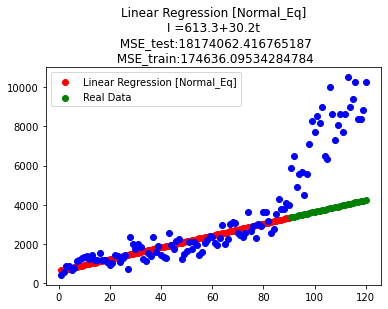

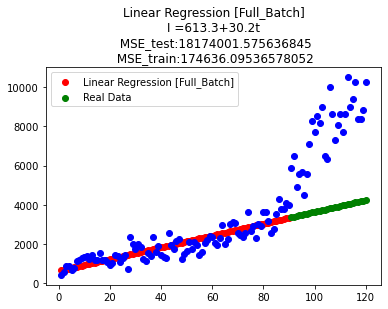

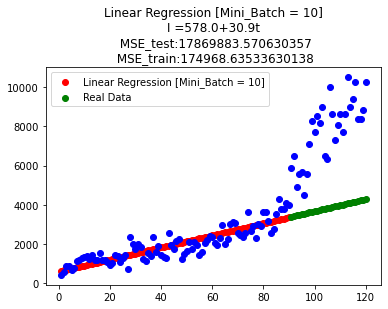

In [15]:
MSE_record = MSE_Summary(model_type ='Normal_Eq',\
                         beta = beta_a,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)
MSE_record = MSE_Summary(model_type ='Full_Batch',\
                         beta = beta_b,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)
MSE_record = MSE_Summary(model_type ='Mini_Batch = 10',\
                         beta = beta_c,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)

# 2. (12 points) Repeat Problem 1 
for quadratic polynomial regression model ( I = A + B t + C t 2 ).

### (a) Compute optimal solution by solving normal equation;

In [16]:
y_train = np.array(Data[:90] ).reshape(-1,1)
y_test = np.array(Data[90:]).reshape(-1,1)
x_train = Transform(X[:90],2)
x_test = Transform(X[90:],2)
beta_a = np.linalg.inv(x_train.T@x_train)@x_train.T@y_train

### (b) compute optimal solution by full batch gradient descent;

In [17]:
beta_b = line_reg_grad_dec(X = X[:90],Y = y_train,
                         n_feature = 2,eta = 0.0000000001, n_iter=1e5,plot = 0)

### (c) compute optimal solution by mini-batch (size 10) stochastic gradient descent;

In [18]:
x_train = Transform(X[:90],2)

In [19]:
n_iterations = 1e4 #Number epoch
minibatch_size = 10 #Selecting n random elements from X_train
np.random.seed(42)#Ensuring Generating Same Result
theta = np.random.randn(2,1) #Random Initialization
beta_c,theta_path = SGD(x_train,y_train,n_iterations,minibatch_size,t0 = 2,t1 = 50000000,tol = 1e-5)

Max Iteration Reached


### (d) compute training and prediction mean square errors for solutions from (a), (b) and (c), and plot model outputs (in red for the first 90 days, in green for the remaining 30 days) along with data (in blue). 

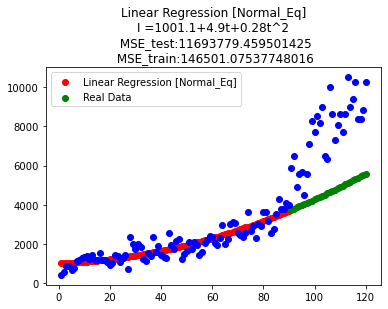

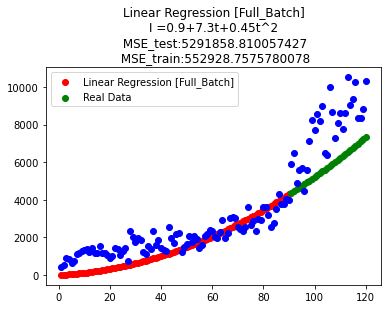

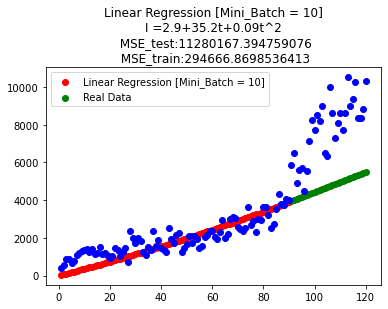

In [20]:
MSE_record = MSE_Summary(model_type ='Normal_Eq',\
                         beta = beta_a,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)
MSE_record = MSE_Summary(model_type ='Full_Batch',\
                         beta = beta_b,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)
MSE_record = MSE_Summary(model_type ='Mini_Batch = 10',\
                         beta = beta_c,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)

### 3. (12 points) Repeat Problem 1 for the cubic polynomial regression
model ( I = A + B t + C t 2 + D t 3 )

### (a) Compute optimal solution by solving normal equation;

In [21]:
y_train = np.array(Data[:90] ).reshape(-1,1)
y_test = np.array(Data[90:]).reshape(-1,1)
x_train = Transform(X[:90],3)
x_test = Transform(X[90:],3)
beta_a = np.linalg.inv(x_train.T@x_train)@x_train.T@y_train

### (b) compute optimal solution by full batch gradient descent;

In [22]:
beta_b = line_reg_grad_dec(X = X[:90],Y = y_train,
                         n_feature = 3,eta = 0.00000000000005, n_iter=1e5,plot = 0)

### (c) compute optimal solution by mini-batch (size 10) stochastic gradient descent;

In [23]:
n_iterations = 1e4 #Number epoch
minibatch_size = 10 #Selecting n random elements from X_train
np.random.seed(42)#Ensuring Generating Same Result
theta = np.random.randn(2,1) #Random Initialization
beta_c,theta_path = SGD(x_train,y_train,n_iterations,minibatch_size,t0 = 2,t1 = 500000000000,tol = 1e-5)

Max Iteration Reached


### (d) compute training and prediction mean square errors for solutions from (a), (b) and (c), and plot model outputs (in red for the first 90 days, in green for the remaining 30 days) along with data (in blue). 

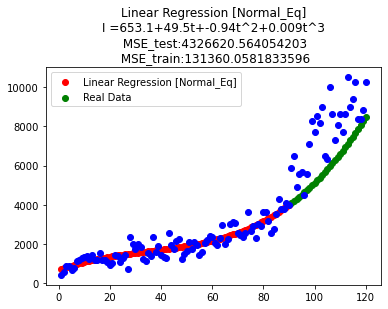

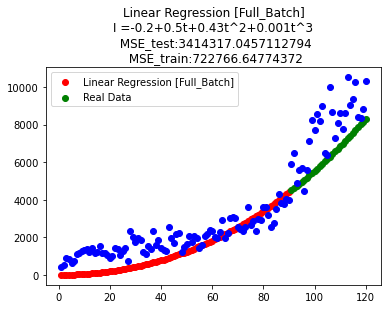

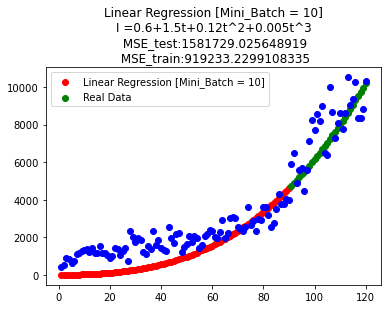

In [24]:
MSE_record = MSE_Summary(model_type ='Normal_Eq',\
                         beta = beta_a,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)
MSE_record = MSE_Summary(model_type ='Full_Batch',\
                         beta = beta_b,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)
MSE_record = MSE_Summary(model_type ='Mini_Batch = 10',\
                         beta = beta_c,x_train = x_train,y_train = y_train,x_test =  x_test,y_test = y_test,MSE_record = MSE_record)

# 4. (4 points) Comment on the models
in Problems 1/2/3 and select the best model for prediction. 

In [26]:
df = pd.DataFrame(MSE_record,index = ['Degree 1', 'Degree 2', 'Degree 3'])
df.head()

,Normal_Eq_train,Full_Batch_train,Mini_Batch = 10_train,Normal_Eq_test,Full_Batch_test,Mini_Batch = 10_test
Degree 1,174636.095343,174636.095366,174968.635336,1.817406e+07,1.817400e+07,1.786988e+07
Degree 2,146501.075377,552928.757578,294666.869854,1.169378e+07,5.291859e+06,1.128017e+07
Degree 3,131360.058183,722766.647744,919233.229911,4.326621e+06,3.414317e+06,1.581729e+06


- Normal (linear Algebra) method performed equally well as the Full-Batch Gradient descent when degree is one. 
- Full-Batch outperformed the other two when degree is 2
- Mini-Batch Outperformed the other two when degree is 3
- A pattern is clear that Normal_Eq method is best at reducing the MSE of the training data,  
 but in terms of prediction     (Testing), it's inferior than the other two. 
- In General,**Mini-Batch** at Degree 3 has the least MSE, and is therefore the best model for prediction:
Namely:   
$I = 0.648 + 1.54t + 0.121 t^2 + 0.0047 t^3 $   
Is best predicts the future based on Past 60 days of Data.
